In [1]:
import networkx as nx
import pandas as pd
import random
from tqdm import tqdm
import numpy as np

In [2]:
G = nx.read_adjlist("data/ca-CondMat.txt", create_using=nx.DiGraph())

In [3]:
node = sorted(G.degree, key=lambda x: x[1], reverse=True)[0][0]

In [4]:
nodes = list(nx.single_source_shortest_path_length(G, node, cutoff=2).keys())

In [5]:
G0 = G.subgraph(nodes)

In [6]:
G0.number_of_nodes(), G0.number_of_edges()

(3403, 38072)

In [7]:
data = random.sample(G0.edges, round(G0.number_of_edges()*0.3))

In [8]:
G0 = nx.DiGraph(G0)

In [9]:
G0.remove_edges_from(data)

In [10]:
pairs = []
for node in tqdm(G0.nodes):
    kneighbors = nx.single_source_shortest_path_length(G0, node, cutoff=2)
    for n in kneighbors:
        if kneighbors[n] == 2 and (n, node) not in pairs:
            pairs.append((node, n))

100%|██████████| 3403/3403 [49:21<00:00,  1.15it/s]  


In [11]:
G0_und = nx.Graph(G0)

In [12]:
indegree_i = []
outdegree_i = []
indegree_j = []
outdegree_j = []
common_neighbors = []
#maxflow = []
shortest_path = []
#katz = []
adamic_adar = []
pref_attach = []
jaccard = []

for pair in tqdm(pairs):
    indegree_i.append(G0.in_degree(pair[0]))
    outdegree_i.append(G0.out_degree(pair[0]))
    indegree_j.append(G0.in_degree(pair[1]))
    outdegree_j.append(G0.out_degree(pair[1]))
    common_neighbors.append(len(list(nx.common_neighbors(G0_und, pair[0],pair[1]))))
    shortest_path.append(nx.shortest_path_length(G0, pair[0], pair[1]))
    adamic_adar.append(list(nx.adamic_adar_index(G0_und, [(pair[0], pair[1])]))[0][2])
    pref_attach.append(list(nx.preferential_attachment(G0_und, [(pair[0], pair[1])]))[0][2])
    jaccard.append(list(nx.jaccard_coefficient(G0_und, [(pair[0], pair[1])]))[0][2])

features = pd.DataFrame({
    'indegree_i': indegree_i,
    'outdegree_i': outdegree_i,
    'indegree_j': indegree_j,
    'outdegree_j': outdegree_j,
    'common_neighbors': common_neighbors,
    'shortest_path': shortest_path,
    'adamic_adar': adamic_adar,
    'pref_attach': pref_attach,
    'jaccard': jaccard
},columns=['indegree_i', 'outdegree_i', 'indegree_j', 'outdegree_j', 'common_neighbors', 'shortest_path',
'adamic_adar', 'pref_attach', 'jaccard'], index=pairs)

100%|██████████| 231431/231431 [01:47<00:00, 2148.70it/s]


In [46]:
features

,indegree_i,outdegree_i,indegree_j,outdegree_j,common_neighbors,shortest_path,adamic_adar,pref_attach,jaccard
"(2183, 38606)",3,3,11,11,1,2,0.267546,33,0.076923
"(2183, 59680)",3,3,2,2,1,2,0.267546,6,0.250000
"(2183, 101355)",3,3,53,53,1,2,0.267546,159,0.018182
"(2183, 49973)",3,3,2,2,1,2,0.267546,6,0.250000
"(2183, 17379)",3,3,2,2,1,2,0.267546,6,0.250000
...,...,...,...,...,...,...,...,...,...
"(80470, 6378)",6,6,6,6,1,2,0.253085,36,0.090909
"(98214, 11214)",4,4,4,4,1,2,0.513898,16,0.142857
"(32029, 11214)",1,1,4,4,1,2,0.402430,4,0.250000
"(72993, 71548)",3,3,17,17,1,2,0.228862,51,0.052632


In [13]:
label = []
for i, row in features.iterrows():
    if i in data or (i[1], i[0]) in data:
        label.append(1)
    else:
        label.append(0)
features['label'] = label

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features[[
    'indegree_i', 'outdegree_i', 'indegree_j', 'outdegree_j', 'common_neighbors', 'shortest_path',
    'adamic_adar', 'pref_attach', 'jaccard']].values, features['label'], test_size=0.3, random_state=0)

In [93]:
clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

In [59]:
print("Initial minority class ratio:", y_test.value_counts()[1] / y_test.value_counts()[0])

Initial minority class ratio: 0.08273708344863027


In [94]:
maj_precision = [report['0']['precision']]
maj_recall = [report['0']['recall']]
maj_f1 = [report['0']['f1-score']]
min_precision = [report['1']['precision']]
min_recall = [report['1']['recall']]
min_f1 = [report['1']['f1-score']]
accuracy = [report['accuracy']]
precision = [report['weighted avg']['precision']]
recall = [report['weighted avg']['recall']]
f1 = [report['weighted avg']['f1-score']]

In [95]:
for ratio in [0.2, 0.4, 0.6, 0.8, 1.0]:
    # print(f"----RATIO:{ratio}----")
    undersample = RandomUnderSampler(sampling_strategy=ratio)
    # transform the dataset
    X_train_us, y_train_us = undersample.fit_resample(X_train, y_train)
    clf = LogisticRegression().fit(X_train_us, y_train_us)
    y_pred = clf.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)

    maj_precision.append(report['0']['precision'])
    maj_recall.append(report['0']['recall'])
    maj_f1.append(report['0']['f1-score'])
    min_precision.append(report['1']['precision'])
    min_recall.append(report['1']['recall'])
    min_f1.append(report['1']['f1-score'])
    accuracy.append(report['accuracy'])
    precision.append(report['weighted avg']['precision'])
    recall.append(report['weighted avg']['recall'])
    f1.append(report['weighted avg']['f1-score'])

c:\Users\ineso\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ineso\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [82]:
import matplotlib.pyplot as plt

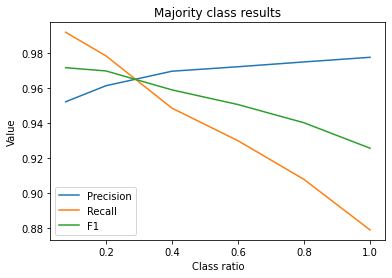

In [96]:
ratios = [y_test.value_counts()[1] / y_test.value_counts()[0], 0.2, 0.4, 0.6, 0.8, 1.0]
plt.title('Majority class results')
plt.plot(ratios, maj_precision, label='Precision')
plt.plot(ratios, maj_recall, label='Recall')
plt.plot(ratios, maj_f1, label='F1')
plt.xlabel('Class ratio')
plt.ylabel('Value')
plt.legend()
plt.show()

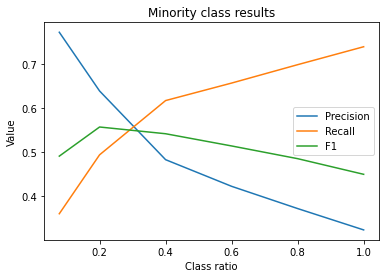

In [97]:
ratios = [y_test.value_counts()[1] / y_test.value_counts()[0], 0.2, 0.4, 0.6, 0.8, 1.0]
plt.title('Minority class results')
plt.plot(ratios, min_precision, label='Precision')
plt.plot(ratios, min_recall, label='Recall')
plt.plot(ratios, min_f1, label='F1')
plt.xlabel('Class ratio')
plt.ylabel('Value')
plt.legend()
plt.show()

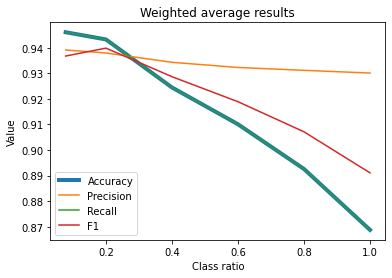

In [106]:
plt.title('Weighted average results')
plt.plot(ratios, accuracy, label='Accuracy', linewidth=4)
plt.plot(ratios, precision, label='Precision')
plt.plot(ratios, recall, label='Recall')
plt.plot(ratios, f1, label='F1')
plt.xlabel('Class ratio')
plt.ylabel('Value')
plt.legend()
plt.show()

In [109]:
results = pd.DataFrame({
    'ratio': ratios,
    'majority precision': maj_precision,
    'majority recall': maj_recall,
    'majority f1': maj_f1,
    'minority precision': min_precision,
    'minority recall': min_recall,
    'minority f1': min_f1,
    'accuracy': accuracy,
    'weighted avg precision': precision,
    'weighted avg recall': recall,
    'weighted avg f1': f1
}).set_index('ratio')

In [128]:
results.index = results.index.map('{:,.3f}'.format)

In [129]:
for col in results.columns:
    results[col] = results[col].map('{:,.3f}'.format)

In [111]:
results.to_csv('results.csv')